# Project description

**Customer churn**

Customers have started leaving **Beta Bank**. Every month. It's not a lot, but it's noticeable. Bank marketers have determined that retaining current customers is more cost-effective than acquiring new ones.

The objective is to predict whether a customer will leave the bank in the near future or not, using historical data on customer behavior and contract terminations. The goal is to construct a model that achieves the highest possible `F1-score`, with a minimum threshold of `0.59` required to successfully complete the project. It is essential to verify the `F1-score` on the test set.

Additionally, the `AUC-ROC` should be measured and compared to the `F1-score`.

Data source: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling


# Table of contents

---

1. [Data](#data)
    * [Preprocessing](#data-prep)
    * [Exploratory data analysis](#data-eda)
    * [Datasets split](#data-split)
    * [Conclusion (Data)](#data-conclusion)
2. [Class balance](#class-balance)
    * [Models training](#class-models-training)
    * [Conclusion](#class-conslusion)
3. [Balancing the classes](#balancing-the-classes)
    * [Upsampling](#balancing-upsampling)
    * [Downsampling](#balancing-downsampling)
    * [Conclusion](#balancing-conclusion)
4. [Testing the best model](#testing)
5. [General conclusion](#general-conclusion)
---

## Data <a class="anchor" id="data"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from tqdm import tqdm

In [2]:
# Locating the CSV with several locations
try:
    df = pd.read_csv('/datasets/churn.csv')
except FileNotFoundError:
    try:
        df = pd.read_csv('churn.csv')
    except FileNotFoundError:
        try:
            df = pd.read_csv(r'churn.csv')
        except FileNotFoundError:
            print('File not found')

# Ignorig all warnings and displaying all columns in the DF
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Print basic info of dataframe
print(f'Shape of dataframe: {df.shape}')
print('-' * 26)
print('\nMissing values:')
print(df.isna().mean().sort_values())
print('-' * 26)
print(f'\nDuplicates: {df.duplicated().sum()}')
print('-' * 26)
print('\nData types:')
print(df.dtypes)
display(df.describe())
display(df.head())

Shape of dataframe: (10000, 14)
--------------------------

Missing values:
RowNumber          0.0000
CustomerId         0.0000
Surname            0.0000
CreditScore        0.0000
Geography          0.0000
Gender             0.0000
Age                0.0000
Balance            0.0000
NumOfProducts      0.0000
HasCrCard          0.0000
IsActiveMember     0.0000
EstimatedSalary    0.0000
Exited             0.0000
Tenure             0.0909
dtype: float64
--------------------------

Duplicates: 0
--------------------------

Data types:
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Preprocessing <a class="anchor" id="data-prep"></a>

The column `df['Tenure']` contains missing values, let's take a look at them and decide what we can do to process them.

In [3]:
df['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

The `df['Tenure']` column contains both zeros and NaN values. Let's count how many NaN values there are.

In [4]:
# Calculate the number of 0s and NaNs in the Tenure column
tenure_z = (df['Tenure'] == 0).sum()
tenure_nan = df['Tenure'].isna().sum()

# Calculate the total number of missing values in the Tenure column
total_missing = tenure_nan + tenure_z

# Print the results
print(f"The amount of '0' in the 'Tenure' column: {tenure_z}")
print(f"Amount of 'NaN': {tenure_nan}")
print(f"The total amount of missing values: {total_missing}")

The amount of '0' in the 'Tenure' column: 382
Amount of 'NaN': 909
The total amount of missing values: 1291


Given the input data, the `df['Tenure']` column contains information about how long a person has been a client of the bank. It can be assumed that the value of 0 corresponds to the fact that the person has been a client for less than a year.

I assume that the NaN values are either incorrectly entered data or simply missing values, but the data may be needed for further work. We remove NaN values (with a placeholder of `"-1"`).

In [5]:
df['Tenure'] = np.where((np.isnan(df.Tenure)), -1, df.Tenure)
df.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,-1.0,130142.79,1,1,0,38190.78,0


### Exploratory data analysis <a class="anchor" id="data-eda"></a>

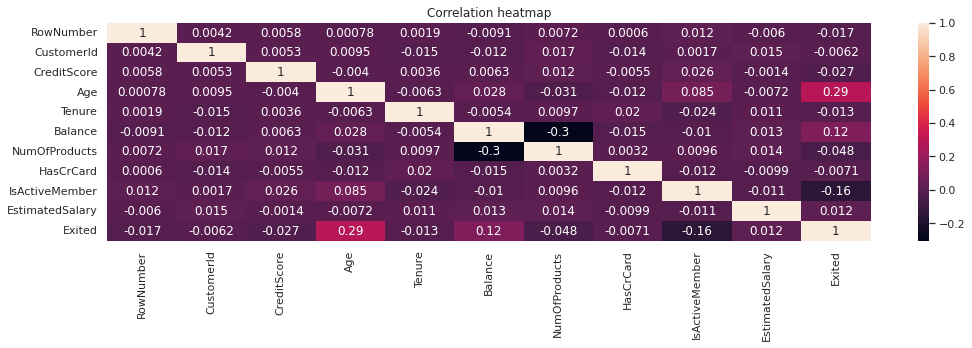

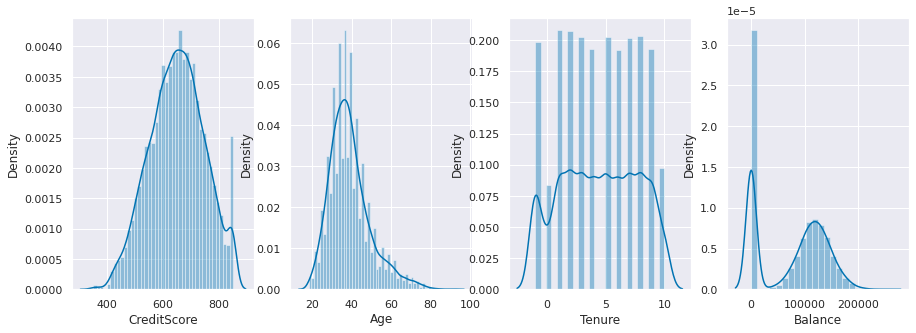

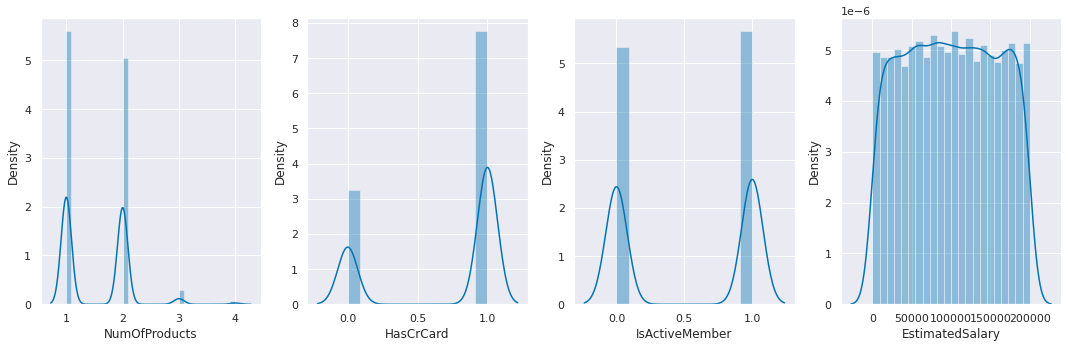

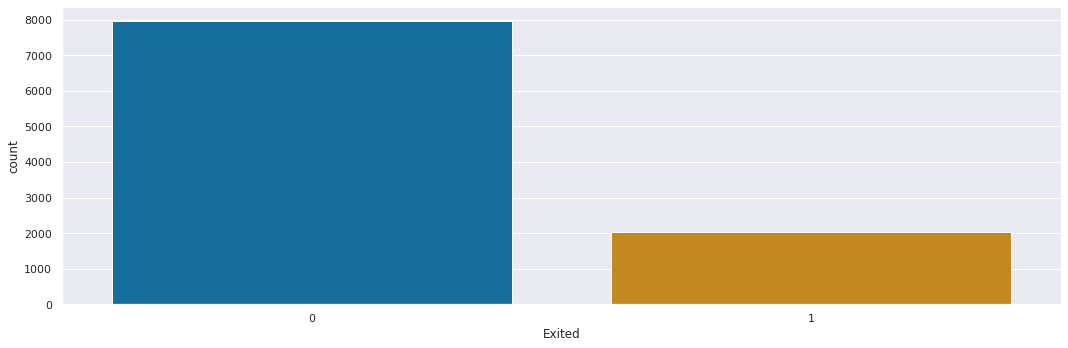

Mean values of the numerical columns:
Credit Score: 651.0
Age: 39.0
Tenure: 4.0
Balance: 76486.0
Estimated Salary: 100090.24


In [6]:
sns.set(rc={'figure.figsize': (15, 5)}, color_codes=True, palette='colorblind')

# Heatmap
sns.heatmap(df.corr(), cbar=True, cmap='rocket', annot=True)
plt.title('Correlation heatmap')
plt.tight_layout()
plt.show()

# Set the figure size
fig, axs = plt.subplots(ncols=4, figsize=(15, 5))

# Create the first subplot with the first four columns
sns.distplot(df['CreditScore'], ax=axs[0])
sns.distplot(df['Age'], ax=axs[1])
sns.distplot(df['Tenure'], ax=axs[2])
sns.distplot(df['Balance'], ax=axs[3])

# Set the figure size for the second subplot
fig, axs = plt.subplots(ncols=4, figsize=(15, 5))

# Create the second subplot with the remain columns
sns.distplot(df['NumOfProducts'], ax=axs[0])
sns.distplot(df['HasCrCard'], ax=axs[1])
sns.distplot(df['IsActiveMember'], ax=axs[2])
sns.distplot(df['EstimatedSalary'], ax=axs[3])
plt.tight_layout()
plt.show()

# Countplot of the 'Exited' columns
sns.countplot(df['Exited'])
plt.tight_layout()
plt.show()

# Print the values
print(f"Mean values of the numerical columns:")
print(f"Credit Score: {df['CreditScore'].mean().round()}")
print(f"Age: {df['Age'].mean().round()}")
print(f"Tenure: {df['Tenure'].mean().round()}")
print(f"Balance: {df['Balance'].mean().round()}")
print(f"Estimated Salary: {df['EstimatedSalary'].mean().round(2)}")

### Datasets split <a class="anchor" id="data-split"></a>

Preparing the features using one-hot encoding. The row number, surname, and customer ID are not required in this case and will be removed. The target feature for this task is the data in the `Exited` column. Prepare the features and target  accordingly, and at this stage, the dataset will be split in a 3:1:1 ratio.

In [7]:
# Prepare data with one-hot encoding
df_ohe = df.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1)
df_ohe = pd.get_dummies(df_ohe, drop_first=True)

# Split data into training, validation, and test sets
target = df_ohe['Exited']
features = df_ohe.drop('Exited', axis=1)

X_train, X_valid_test, y_train, y_valid_test = train_test_split(
    features, target, test_size=0.4, stratify=target, random_state=8080
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid_test, y_valid_test, test_size=0.5, stratify=y_valid_test, random_state=8080
)

# Print proportions of each set
data_sets = {'Training': X_train,
             'Validation': X_valid,
             'Test': X_test
}
total_size = df_ohe.shape[0]

print(f"Total size: {total_size}")

for name, data in data_sets.items():
    prop = data.shape[0] / total_size
    print(f"{name} set proportion: {prop:.0%}")

Total size: 10000
Training set proportion: 60%
Validation set proportion: 20%
Test set proportion: 20%


Adding numerical features to the variable `numeric` and scaling the data.

In [8]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

### Conclusion (Data)  <a class="anchor" id="data-conclusion"></a>

1. During data preprocessing, missing values **NaN** were found in the Tenure column, and they were replaced with a placeholder value of `"-1"`. Zero values in the column accounted for *9%* of the data.
2. During exploratory data analysis (EDA), it was observed that there was no strong dependence between the variables, and the data was mostly normally distributed. Also the following was determined:
    - The average credit score was 651;
    - The average age was 39 years;
    - On average, clients worked with the bank for 5 years;
    - The average salary for clients was around 100,000;
    - Many clients had a balance of zero, but the average balance was 76,000;
    - The number of products held by clients in descending order was 1, 2, 3+;
    - More than half of the clients did not have a credit card;
    - Approximately half of the entire sample of clients was active;
    - 80% of clients remained with the bank.
3. During the preparation of the datasets, *60%* was allocated for `training`, *20%* for `validation`, and *20%* for `test`. The `features` and `numerical features` were identified and scaled.

## Class balance <a class="anchor" id="class-balance"></a>


It is necessary to investigate the class balance. Given that during EDA it was determined that *80%* of customers remain with the bank, class imbalance is evident.

### Models training <a class="anchor" id="class-models-training"></a>

Training the `RandomForestClassifier` model without considering class imbalance, using hyperparameter tuning.

In [9]:
%%time

best_result = {'depth_rfc': 0, 'est': 0, 'auc_roc': 0, 'f1': 0}

for depth_rfc in tqdm(range(15, 23, 1)):
    for est in range(190, 220, 10):
        model_rfc = RandomForestClassifier(
            random_state=8080,
            max_depth=depth_rfc,
            n_estimators=est
        )
        model_rfc.fit(X_train, y_train)
        predictions = model_rfc.predict(X_valid)
        auc_roc_rfc = roc_auc_score(y_valid, predictions)
        f1_rfc = f1_score(y_valid, predictions)
        if auc_roc_rfc > best_result['auc_roc']:
            best_result['depth_rfc'] = depth_rfc
            best_result['est'] = est
            best_result['auc_roc'] = auc_roc_rfc
            best_result['f1'] = f1_rfc

print(f"\nBest parameters and results:")
print(f"max_depth: {best_result['depth_rfc']}")
print(f"n_estimators: {best_result['est']}")
print(f"auc_roc: {best_result['auc_roc']:.2f}")
print(f"f1: {best_result['f1']:.2f}")

100%|██████████| 8/8 [01:06<00:00,  8.27s/it]


Best parameters and results:
max_depth: 19
n_estimators: 200
auc_roc: 0.73
f1: 0.60
CPU times: user 53.9 s, sys: 251 ms, total: 54.2 s
Wall time: 1min 6s


ROC curve for the model with the best parameters, added accuracy and recall.

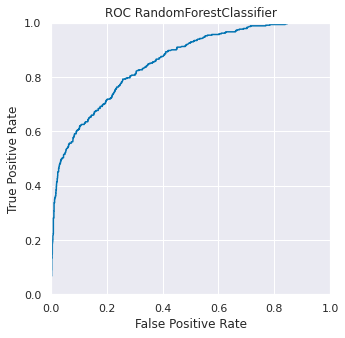

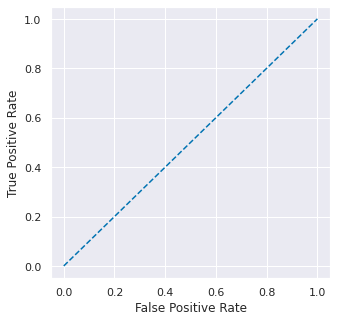

ROC-AUC: 0.73
F1: 0.60
Accuracy: 0.87
Recall: 0.48


In [10]:
model_rfc = RandomForestClassifier(
    random_state=8080,
    max_depth=best_result['depth_rfc'],
    n_estimators=best_result['est']
)
model_rfc.fit(X_train, y_train)
predictions = model_rfc.predict(X_valid)
auc_roc_rfc = roc_auc_score(y_valid, predictions)
f1_rfc = f1_score(y_valid, predictions)
accuracy_rfc = accuracy_score(y_valid, predictions)
recall_rfc = recall_score(y_valid, predictions)

probabilities_valid = model_rfc.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC RandomForestClassifier')

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

print(f"ROC-AUC: {auc_roc_rfc:.2f}")
print(f"F1: {f1_rfc:.2f}")
print(f"Accuracy: {accuracy_rfc:.2f}")
print(f"Recall: {recall_rfc:.2f}")

Training the `LogisticRegression` model without considering class imbalance, using hyperparameter tuning.

In [11]:
%%time

solvers = ['newton-cg', 'lbfgs', 'liblinear']

best_result = {'solver': '', 'max_iter': 0, 'auc_roc': 0, 'f1': 0}

for solver in tqdm(solvers):
    for max_iter in range(1, 20, 1):
        model_lr = LogisticRegression(
            random_state=8080,
            penalty='l2',
            solver=solver,
            max_iter=max_iter)
        model_lr.fit(X_train, y_train)
        predictions = model_lr.predict(X_valid)
        auc_roc_lr = roc_auc_score(y_valid, predictions)
        f1_lr = f1_score(y_valid, predictions)
        if auc_roc_lr > best_result['auc_roc']:
            best_result['solver'] = solver
            best_result['max_iter'] = max_iter
            best_result['auc_roc'] = auc_roc_lr
            best_result['f1'] = f1_lr

print(f"\nBest parameters and results:")
print(f"solver: {best_result['solver']}")
print(f"max_iter: {best_result['max_iter']}")
print(f"auc_roc: {best_result['auc_roc']:.2f}")
print(f"f1: {best_result['f1']:.2f}")

100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


Best parameters and results:
solver: lbfgs
max_iter: 7
auc_roc: 0.58
f1: 0.31
CPU times: user 2.1 s, sys: 1.57 s, total: 3.66 s
Wall time: 1.98 s


ROC curve for the model with the best parameters, added accuracy and recall.

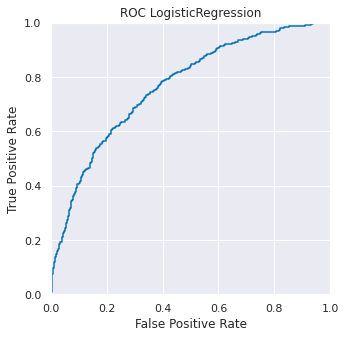

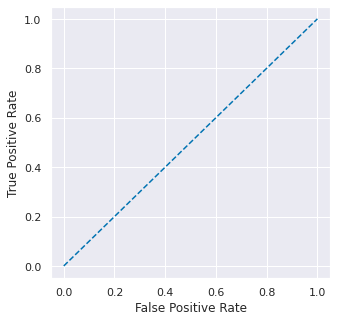

ROC-AUC: 0.58
F1: 0.31
Accuracy: 0.81
Recall: 0.21


In [12]:
model_lr = LogisticRegression(
    random_state=8080,
    penalty='l2',
    solver=best_result['solver'], 
    max_iter=best_result['max_iter']
)
model_lr.fit(X_train, y_train)
predictions = model_lr.predict(X_valid)
auc_roc_lr = roc_auc_score(y_valid, predictions)
f1_lr = f1_score(y_valid, predictions)
accuracy_lr = accuracy_score(y_valid, predictions)
recall_lr = recall_score(y_valid, predictions)

probabilities_valid = model_lr.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC LogisticRegression')

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

print(f"ROC-AUC: {auc_roc_lr:.2f}")
print(f"F1: {f1_lr:.2f}")
print(f"Accuracy: {accuracy_lr:.2f}")
print(f"Recall: {recall_lr:.2f}")

Training the `DecisionTreeClassifier` model without considering class imbalance, using hyperparameter tuning.

In [13]:
%%time

best_result = {
    'depth_dtc': 0, 'features': None, 'samples': 0, 'auc_roc': 0, 'f1': 0
}

for depth_dtc in tqdm(range(1, 10)):
    for feature in ['auto', 'sqrt', None]:
        for samples in range(10, 20, 1):
            model_dtc = DecisionTreeClassifier(
                random_state=8080,
                max_depth=depth_dtc,
                max_features=feature,
                min_samples_split=samples
            )
            model_dtc.fit(X_train, y_train)
            predictions = model_dtc.predict(X_valid)
            auc_roc_dtc = roc_auc_score(y_valid, predictions)
            f1_dtc = f1_score(y_valid, predictions)
            if auc_roc_dtc > best_result['auc_roc']:
                best_result['depth_dtc'] = depth_dtc
                best_result['features'] = feature
                best_result['samples'] = samples
                best_result['auc_roc'] = auc_roc_dtc
                best_result['f1'] = f1_dtc

print(f"\nBest parameters and results:")
print(f"max_depth: {best_result['depth_dtc']}")
print(f"max_features: {best_result['features']}")
print(f"min_samples_split: {best_result['samples']}")
print(f"auc_roc: {best_result['auc_roc']:.2f}")
print(f"f1: {best_result['f1']:.2f}")

100%|██████████| 9/9 [00:04<00:00,  2.02it/s]


Best parameters and results:
max_depth: 9
max_features: None
min_samples_split: 17
auc_roc: 0.72
f1: 0.58
CPU times: user 4.41 s, sys: 25.3 ms, total: 4.44 s
Wall time: 4.47 s


ROC curve for the model with the best parameters, added accuracy and recall.

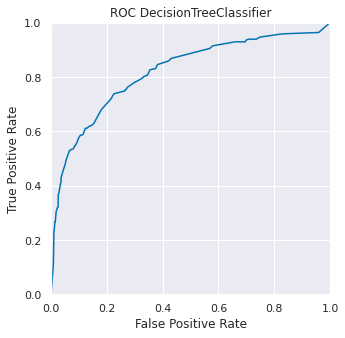

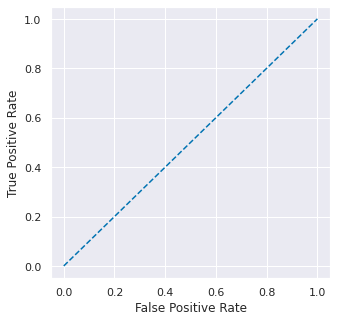

ROC-AUC: 0.72
F1: 0.58
Accuracy: 0.85
Recall: 0.49


In [14]:
model_dtc = DecisionTreeClassifier(
    random_state=8080,
    max_depth=best_result['depth_dtc'],
    max_features=best_result['features'],
    min_samples_split=best_result['samples']
)
model_dtc.fit(X_train, y_train)
predictions = model_dtc.predict(X_valid)
auc_roc_dtc = roc_auc_score(y_valid, predictions)
f1_dtc = f1_score(y_valid, predictions)
accuracy_dtc = accuracy_score(y_valid, predictions)
recall_dtc = recall_score(y_valid, predictions)

probabilities_valid = model_dtc.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC DecisionTreeClassifier')

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

print(f"ROC-AUC: {auc_roc_dtc:.2f}")
print(f"F1: {f1_dtc:.2f}")
print(f"Accuracy: {accuracy_dtc:.2f}")
print(f"Recall: {recall_dtc:.2f}")

In [15]:
# Collecting results in dataframe
data = {
    'Model': ['RandomForestClassifier', 'LogisticRegression', 'DecisionTreeClassifier'],
    'ROC-AUC': [round(auc_roc_rfc, 2), round(auc_roc_lr, 2), round(auc_roc_dtc, 2)],
    'F1': [round(f1_rfc, 2), round(f1_lr, 2), round(f1_dtc, 2)],
    'Accuracy': [round(accuracy_rfc, 2), round(accuracy_lr, 2), round(accuracy_dtc, 2)],
    'Recall': [round(recall_rfc, 2), round(recall_lr, 2), round(recall_dtc, 2)],
    'Dataset': ['Unbalanced', 'Unbalanced', 'Unbalanced']
}

results = pd.DataFrame(data)
results

,Model,ROC-AUC,F1,Accuracy,Recall,Dataset
0,RandomForestClassifier,0.73,0.60,0.87,0.48,Unbalanced
1,LogisticRegression,0.58,0.31,0.81,0.21,Unbalanced
2,DecisionTreeClassifier,0.72,0.58,0.85,0.49,Unbalanced


### Conclusion <a class="anchor" id="class-conslusion"></a>
During the research, it was found that the class imbalance was *80%* and *20%*. The models `RandomForestClassifier`, `LogisticRegression`, and `DecisionTreeClassifier` were trained. The best hyperparameters were selected by tuning them in the loop.

The highest score was obtained by the `RandomForestClassifier (max_depth=18; n_estimators=210)` model.

## Balancing the classes <a class="anchor" id="balancing-the-classes"></a>

### Upsampling <a class="anchor" id="balancing-upsampling"></a>

To restore balance of the classes (rebalancing), will be applied Upsampling - increasing the dataset size.

In [16]:
def upsample(features, target, repeat):
    """
    1. Separate the features and target by class
    2. Create new upsampled dataset by concatenating
    the minority class with itself 'repeat' times
    3. Shuffle the upsampled dataset
    4. Display shapes of original classes
    """
    X_zeros = features[target == 0]
    X_ones = features[target == 1]
    y_zeros = target[target == 0]
    y_ones = target[target == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(
        X_upsampled, y_upsampled, random_state=8080
    )
    
    display(X_zeros.shape)
    display(X_ones.shape)
    display(y_zeros.shape)
    display(y_ones.shape)
    
    return X_upsampled, y_upsampled

# Example usage: upsample X_train and y_train with repeat=10
X_upsampled, y_upsampled = upsample(X_train, y_train, 10)

(4778, 11)

(1222, 11)

(4778,)

(1222,)

**Models training**

Training the model on the new upsampled dataset and searching for the best hyperparameters.

`RandomForestClassifier`:

In [17]:
%%time

best_result = {'depth': 0, 'est': 0, 'auc_roc': 0, 'f1': 0}

for depth in tqdm(range(15, 20, 1)):
    for est in range(150, 200, 10):
        model_rfc = RandomForestClassifier(
            random_state=8080,
            max_depth=depth,
            n_estimators=est
        )
        model_rfc.fit(X_upsampled, y_upsampled)
        predictions = model_rfc.predict(X_valid)
        auc_roc_rfc = roc_auc_score(y_valid, predictions)
        f1_rfc = f1_score(y_valid, predictions)
        if auc_roc_rfc > best_result['auc_roc']:
            best_result['depth'] = depth
            best_result['est'] = est
            best_result['auc_roc'] = auc_roc_rfc
            best_result['f1'] = f1_rfc

print(f"\nBest parameters and results:")
print(f"max_depth: {best_result['depth']}")
print(f"n_estimators: {best_result['est']}")
print(f"auc_roc: {best_result['auc_roc']:.2f}")
print(f"f1: {best_result['f1']:.2f}")

100%|██████████| 5/5 [01:29<00:00, 17.81s/it]


Best parameters and results:
max_depth: 16
n_estimators: 180
auc_roc: 0.75
f1: 0.61
CPU times: user 1min 20s, sys: 306 ms, total: 1min 21s
Wall time: 1min 29s


In [18]:
model_rfc = RandomForestClassifier(
    random_state=8080,
    max_depth=best_result['depth'],
    n_estimators=best_result['est']
)
model_rfc.fit(X_upsampled, y_upsampled)
predictions = model_rfc.predict(X_valid)
auc_roc_rfc = roc_auc_score(y_valid, predictions)
f1_rfc = f1_score(y_valid, predictions)
accuracy_rfc = accuracy_score(y_valid, predictions)
recall_rfc = recall_score(y_valid, predictions)

`LogisticRegression`:

In [19]:
%%time

solvers = ['newton-cg', 'lbfgs', 'liblinear']

best_result = {'solver': '', 'max_iter': 0, 'auc_roc': 0, 'f1': 0}

for solver in tqdm(solvers):
    for max_iter in range(1, 20, 1):
        model_lr = LogisticRegression(
            random_state=8080,
            penalty='l2',
            solver=solver,
            max_iter=max_iter)
        model_lr.fit(X_upsampled, y_upsampled)
        predictions = model_lr.predict(X_valid)
        auc_roc_lr = roc_auc_score(y_valid, predictions)
        f1_lr = f1_score(y_valid, predictions)
        if auc_roc_lr > best_result['auc_roc']:
            best_result['solver'] = solver
            best_result['max_iter'] = max_iter
            best_result['auc_roc'] = auc_roc_lr
            best_result['f1'] = f1_lr

print(f"\nBest parameters and results:")
print(f"solver: {best_result['solver']}")
print(f"max_iter: {best_result['max_iter']}")
print(f"auc_roc: {best_result['auc_roc']:.2f}")
print(f"f1: {best_result['f1']:.2f}")

100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Best parameters and results:
solver: newton-cg
max_iter: 2
auc_roc: 0.66
f1: 0.43
CPU times: user 4.08 s, sys: 2.93 s, total: 7 s
Wall time: 3.76 s


In [20]:
model_lr = LogisticRegression(
    random_state=8080,
    penalty='l2',
    solver=best_result['solver'],
    max_iter=best_result['max_iter']
)
model_lr.fit(X_upsampled, y_upsampled)
predictions = model_lr.predict(X_valid)
auc_roc_lr = roc_auc_score(y_valid, predictions)
f1_lr = f1_score(y_valid, predictions)
accuracy_lr = accuracy_score(y_valid, predictions)
recall_lr = recall_score(y_valid, predictions)

`DecisionTreeClassifier`:

In [21]:
%%time

best_result = {
    'depth': 0, 'features': None, 'samples': 0, 'auc_roc': 0, 'f1': 0
}

for depth in tqdm(range(1, 10)):
    for feature in ['auto', 'sqrt', None]:
        for samples in range(2, 10, 1):
            model_dtc = DecisionTreeClassifier(
                random_state=8080,
                max_depth=depth,
                max_features=feature,
                min_samples_split=samples
            )
            model_dtc.fit(X_upsampled, y_upsampled)
            predictions = model_dtc.predict(X_valid)
            auc_roc_dtc = roc_auc_score(y_valid, predictions)
            f1_dtc = f1_score(y_valid, predictions)
            if auc_roc_dtc > best_result['auc_roc']:
                best_result['depth'] = depth
                best_result['features'] = feature
                best_result['samples'] = samples
                best_result['auc_roc'] = auc_roc_dtc
                best_result['f1'] = f1_dtc

print(f"\nBest parameters and results:")
print(f"max_depth: {best_result['depth']}")
print(f"max_features: {best_result['features']}")
print(f"min_samples_split: {best_result['samples']}")
print(f"auc_roc: {best_result['auc_roc']:.2f}")
print(f"f1: {best_result['f1']:.2f}")

100%|██████████| 9/9 [00:05<00:00,  1.67it/s]


Best parameters and results:
max_depth: 7
max_features: None
min_samples_split: 2
auc_roc: 0.75
f1: 0.53
CPU times: user 5.37 s, sys: 89.8 ms, total: 5.46 s
Wall time: 5.42 s


In [22]:
model_dtc = DecisionTreeClassifier(
    random_state=8080,
    max_depth=best_result['depth'],
    max_features=best_result['features'],
    min_samples_split=best_result['samples']
)
model_dtc.fit(X_upsampled, y_upsampled)
predictions = model_dtc.predict(X_valid)
auc_roc_dtc = roc_auc_score(y_valid, predictions)
f1_dtc = f1_score(y_valid, predictions)
accuracy_dtc = accuracy_score(y_valid, predictions)
recall_dtc = recall_score(y_valid, predictions)

Evaluation metrics of trained models on upsampled dataset:

In [23]:
data = {
    'Model': ['RandomForestClassifier', 'LogisticRegression', 'DecisionTreeClassifier'],
    'ROC-AUC': [round(auc_roc_rfc, 2), round(auc_roc_lr, 2), round(auc_roc_dtc, 2)],
    'F1': [round(f1_rfc, 2), round(f1_lr, 2), round(f1_dtc, 2)],
    'Accuracy': [round(accuracy_rfc, 2), round(accuracy_lr, 2), round(accuracy_dtc, 2)],
    'Recall': [round(recall_rfc, 2), round(recall_lr, 2), round(recall_dtc, 2)],
    'Dataset': ['Upsampled', 'Upsampled', 'Upsampled']
}

results_upsampled = pd.DataFrame(data)
results_upsampled

,Model,ROC-AUC,F1,Accuracy,Recall,Dataset
0,RandomForestClassifier,0.75,0.61,0.84,0.59,Upsampled
1,LogisticRegression,0.66,0.43,0.52,0.89,Upsampled
2,DecisionTreeClassifier,0.75,0.53,0.70,0.83,Upsampled


### Downsampling <a class="anchor" id="balancing-downsampling"></a>

To restore balance of the classes (rebalancing), will be applied Downsampling - decreasing the dataset size.

In [24]:
def downsample(features, target, fraction):
    """
    1. Separate the features and target by class
    2. Perform downsampling by concatenating
    a fraction of the majority class data with the minority class data
    3. Shuffle the upsampled dataset
    4. Display shapes of original classes
    """
    X_zeros = features[target == 0]
    X_ones = features[target == 1]
    y_zeros = target[target == 0]
    y_ones = target[target == 1]

    X_downsampled = pd.concat(
        [X_zeros.sample(frac=fraction, random_state=8080)] + [X_ones]
    )
    y_downsampled = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=8080)] + [y_ones]
    )
    
    X_downsampled, y_downsampled = shuffle(
        X_downsampled, y_downsampled, random_state=8080
    )
    
    display(X_zeros.shape)
    display(X_ones.shape)
    display(y_zeros.shape)
    display(y_ones.shape)
    
    return X_downsampled, y_downsampled

# Call the downsample function with the training data,
# a downsampling fraction of 0.1, and store the resulting downsampled dataset
X_downsampled, y_downsampled = downsample(X_train, y_train, 0.1)

(4778, 11)

(1222, 11)

(4778,)

(1222,)

**Models training**

Training the model on the new downsampled dataset and searching for the best hyperparameters.

`RandomForestClassifier`:

In [25]:
%%time

best_result = {'depth': 0, 'est': 0, 'auc_roc': 0, 'f1': 0}

for depth in tqdm(range(5, 15, 1)):
    for est in range(150, 250, 10):
        model_rfc = RandomForestClassifier(
            random_state=8080,
            max_depth=depth,
            n_estimators=est
        )
        model_rfc.fit(X_downsampled, y_downsampled)
        predictions = model_rfc.predict(X_valid)
        auc_roc_rfc = roc_auc_score(y_valid, predictions)
        f1_rfc = f1_score(y_valid, predictions)
        if auc_roc_rfc > best_result['auc_roc']:
            best_result['depth'] = depth
            best_result['est'] = est
            best_result['auc_roc'] = auc_roc_rfc
            best_result['f1'] = f1_rfc

print(f"\nBest parameters and results:")
print(f"max_depth: {best_result['depth']}")
print(f"n_estimators: {best_result['est']}")
print(f"auc_roc: {best_result['auc_roc']:.2f}")
print(f"f1: {best_result['f1']:.2f}")

100%|██████████| 10/10 [01:19<00:00,  7.97s/it]


Best parameters and results:
max_depth: 12
n_estimators: 190
auc_roc: 0.72
f1: 0.48
CPU times: user 1min 15s, sys: 355 ms, total: 1min 15s
Wall time: 1min 19s


In [26]:
model_rfc = RandomForestClassifier(
    random_state=8080,
    max_depth=best_result['depth'],
    n_estimators=best_result['est']
)
model_rfc.fit(X_downsampled, y_downsampled)
predictions = model_rfc.predict(X_valid)
auc_roc_rfc = roc_auc_score(y_valid, predictions)
f1_rfc = f1_score(y_valid, predictions)
accuracy_rfc = accuracy_score(y_valid, predictions)
recall_rfc = recall_score(y_valid, predictions)

`LogisticRegression`:

In [27]:
%%time

solvers = ['newton-cg', 'lbfgs', 'liblinear']

best_result = {'solver': '', 'max_iter': 0, 'auc_roc': 0, 'f1': 0}

for solver in tqdm(solvers):
    for max_iter in range(1, 20, 1):
        model_lr = LogisticRegression(
            random_state=8080,
            penalty='l2',
            solver=solver,
            max_iter=max_iter)
        model_lr.fit(X_downsampled, y_downsampled)
        predictions = model_lr.predict(X_valid)
        auc_roc_lr = roc_auc_score(y_valid, predictions)
        f1_lr = f1_score(y_valid, predictions)
        if auc_roc_lr > best_result['auc_roc']:
            best_result['solver'] = solver
            best_result['max_iter'] = max_iter
            best_result['auc_roc'] = auc_roc_lr
            best_result['f1'] = f1_lr

print(f"\nBest parameters and results:")
print(f"solver: {best_result['solver']}")
print(f"max_iter: {best_result['max_iter']}")
print(f"auc_roc: {best_result['auc_roc']:.2f}")
print(f"f1: {best_result['f1']:.2f}")

100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


Best parameters and results:
solver: lbfgs
max_iter: 4
auc_roc: 0.65
f1: 0.43
CPU times: user 1.44 s, sys: 1.1 s, total: 2.54 s
Wall time: 1.36 s


In [28]:
model_lr = LogisticRegression(
    random_state=8080,
    penalty='l2',
    solver=best_result['solver'],
    max_iter=best_result['max_iter']
)
model_lr.fit(X_downsampled, y_downsampled)
predictions = model_lr.predict(X_valid)
auc_roc_lr = roc_auc_score(y_valid, predictions)
f1_lr = f1_score(y_valid, predictions)
accuracy_lr = accuracy_score(y_valid, predictions)
recall_lr = recall_score(y_valid, predictions)

`DecisionTreeClassifier`:

In [29]:
%%time

best_result = {
    'depth': 0, 'features': None, 'samples': 0, 'auc_roc': 0, 'f1': 0
}

for depth in tqdm(range(1, 10)):
    for feature in ['auto', 'sqrt', None]:
        for samples in range(2, 10, 1):
            model_dtc = DecisionTreeClassifier(
                random_state=8080,
                max_depth=depth,
                max_features=feature,
                min_samples_split=samples
            )
            model_dtc.fit(X_downsampled, y_downsampled)
            predictions = model_dtc.predict(X_valid)
            auc_roc_dtc = roc_auc_score(y_valid, predictions)
            f1_dtc = f1_score(y_valid, predictions)
            if auc_roc_dtc > best_result['auc_roc']:
                best_result['depth'] = depth
                best_result['features'] = feature
                best_result['samples'] = samples
                best_result['auc_roc'] = auc_roc_dtc
                best_result['f1'] = f1_dtc

print(f"\nBest parameters and results:")
print(f"max_depth: {best_result['depth']}")
print(f"max_features: {best_result['features']}")
print(f"min_samples_split: {best_result['samples']}")
print(f"auc_roc: {best_result['auc_roc']:.2f}")
print(f"f1: {best_result['f1']:.2f}")

100%|██████████| 9/9 [00:02<00:00,  3.65it/s]


Best parameters and results:
max_depth: 7
max_features: None
min_samples_split: 7
auc_roc: 0.71
f1: 0.48
CPU times: user 2.44 s, sys: 90.2 ms, total: 2.53 s
Wall time: 2.47 s


In [30]:
model_dtc = DecisionTreeClassifier(
    random_state=8080,
    max_depth=best_result['depth'],
    max_features=best_result['features'],
    min_samples_split=best_result['samples']
)
model_dtc.fit(X_downsampled, y_downsampled)
predictions = model_dtc.predict(X_valid)
auc_roc_dtc = roc_auc_score(y_valid, predictions)
f1_dtc = f1_score(y_valid, predictions)
accuracy_dtc = accuracy_score(y_valid, predictions)
recall_dtc = recall_score(y_valid, predictions)

Evaluation metrics of trained models on downsampled dataset:

In [31]:
data = {
    'Model': ['RandomForestClassifier', 'LogisticRegression', 'DecisionTreeClassifier'],
    'ROC-AUC': [round(auc_roc_rfc, 2), round(auc_roc_lr, 2), round(auc_roc_dtc, 2)],
    'F1': [round(f1_rfc, 2), round(f1_lr, 2), round(f1_dtc, 2)],
    'Accuracy': [round(accuracy_rfc, 2), round(accuracy_lr, 2), round(accuracy_dtc, 2)],
    'Recall': [round(recall_rfc, 2), round(recall_lr, 2), round(recall_dtc, 2)],
    'Dataset': ['Downsampled', 'Downsampled', 'Downsampled']
}

results_downsampled = pd.DataFrame(data)

In [32]:
# Concatenate the results and reoder by F1
results_final = pd.concat([results, results_upsampled, results_downsampled])
results_final = results_final.sort_values(by='F1', ascending=False)
results_final.style.hide_index()

Model,ROC-AUC,F1,Accuracy,Recall,Dataset
RandomForestClassifier,0.750000,0.610000,0.840000,0.590000,Upsampled
RandomForestClassifier,0.730000,0.600000,0.870000,0.480000,Unbalanced
DecisionTreeClassifier,0.720000,0.580000,0.850000,0.490000,Unbalanced
DecisionTreeClassifier,0.750000,0.530000,0.700000,0.830000,Upsampled
RandomForestClassifier,0.720000,0.480000,0.580000,0.940000,Downsampled
DecisionTreeClassifier,0.710000,0.480000,0.640000,0.830000,Downsampled
LogisticRegression,0.660000,0.430000,0.520000,0.890000,Upsampled
LogisticRegression,0.650000,0.430000,0.490000,0.920000,Downsampled
LogisticRegression,0.580000,0.310000,0.810000,0.210000,Unbalanced


### Conclusion <a class="anchor" id="balancing-conclusion"></a>

The best model for *upsampled* dataset:
- `RandomForestClassifier (max_depth: 16, n_estimators: 180)` with F1 - 0.61.

The best model for *downsampled* dataset:
- `RandomForestClassifier (max_depth: 12, n_estimators: 190)` with F1 - 0.48.

## Testing the best model <a class="anchor" id="testing"></a>

Training the model with hyperparameters showed highest F1 score (upsampled dataset)

In [33]:
model_rfc_test = RandomForestClassifier(
    random_state=8080,
    max_depth=16,
    n_estimators=180
)
model_rfc.fit(X_train, y_train)
predictions = model_rfc.predict(X_test)
auc_roc_rfc = roc_auc_score(y_test, predictions)
f1_rfc = f1_score(y_test, predictions)
accuracy_rfc = accuracy_score(y_test, predictions)
recall_rfc = recall_score(y_test, predictions)

print(f"ROC-AUC: {auc_roc_rfc:.2f}")
print(f"F1: {f1_rfc:.2f}")
print(f"Accuracy: {accuracy_rfc:.2f}")
print(f"Recall: {recall_rfc:.2f}")

ROC-AUC: 0.72
F1: 0.59
Accuracy: 0.86
Recall: 0.48


## General conclusion <a class="anchor" id="general-conclusion"></a>

During the data analysis, it was conducted EDA and found that there is no strong dependence in the data, and for the most part, the data is normally distributed. Also the following was found out:
 - The average credit rating is 651;
 - The average age is 39 years;
 - On average, clients have been working with the bank for 5 years;
 - The average salary of clients is around 100,000;
 - Many clients have a zero balance on their account, but the average balance is 76,000;
 - The number of products in descending order is: 1, 2, 3+;
 - More than half of the clients do not have a credit card;
 - Approximately half of the entire sample of clients is an active part;
 - 80% of clients remain working with the bank.

Three machine learning models were used to achive the aim (F1 is not below of *0.59*): `RandomForestClassifier`, `LogisticRegression`, and `DecisionTreeClassifier`. The best hyperparameters for each model were chosen by iterating through them.
Experiments were conducted for each model on both an upsampled and downsampled datasets to achieve the best results.

The best model was determined:

In [34]:
model_rfc_test

RandomForestClassifier(max_depth=16, n_estimators=180, random_state=8080)

which achieved the following results:

| ROC-AUC | F1 | Accuracy | Recall |
|--|--|--|--|
| 0.72 | 0.59 | 0.86 | 0.49 |